# Overview

The task consists of creating a *Machine Learning* model capable of predicting the median house price by district in California.

To do this, we will use a *dataset* of data from each census block in California from the 1990 census, with some modifications for educational purposes. Additionally, the dataset is not current, which is a bias that makes this dataset not very useful for the purpose we seek, but it is a good example for learning to work with real data if we set aside that fact (although it is very important to identify it).

This [dataset can be downloaded from Kaggle](https://www.kaggle.com/camnugent/california-housing-prices), along with details of its content and you can also find multiple notebooks like this one with different analyses and processing of the data.

## First approach to the data

We start from the *dataset* in a csv file, which we load into a **DataFrame** from **pandas**.

In [ ]:
import pandas as pd
housing = pd.read_csv("./data/housing.csv")

In [ ]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We observe that the dataset has 10 columns, and 20640 rows. It's a small number of rows for a *Machine Learning* dataset, but it's a good example for learning. We could work with much larger files, and if the dataset is too large, we would have to use **Big Data** *frameworks*.

In [ ]:
housing.isnull().sum() # Check the number of null values

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

All columns are numeric, except 'ocean_proximity', which is of type "object". This type can contain any Python object, but having been read from a CSV we know it is text. We analyze its values to confirm that it is a **categorical variable** with 5 possible values indicating proximity to the ocean.

In [ ]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

We use the ```describe()``` method to get a summary of statistics for each numeric column. Null values will be ignored when calculating these statistics.
We can also use the ```hist()``` method to get a histogram of each numeric column and see its distribution.

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


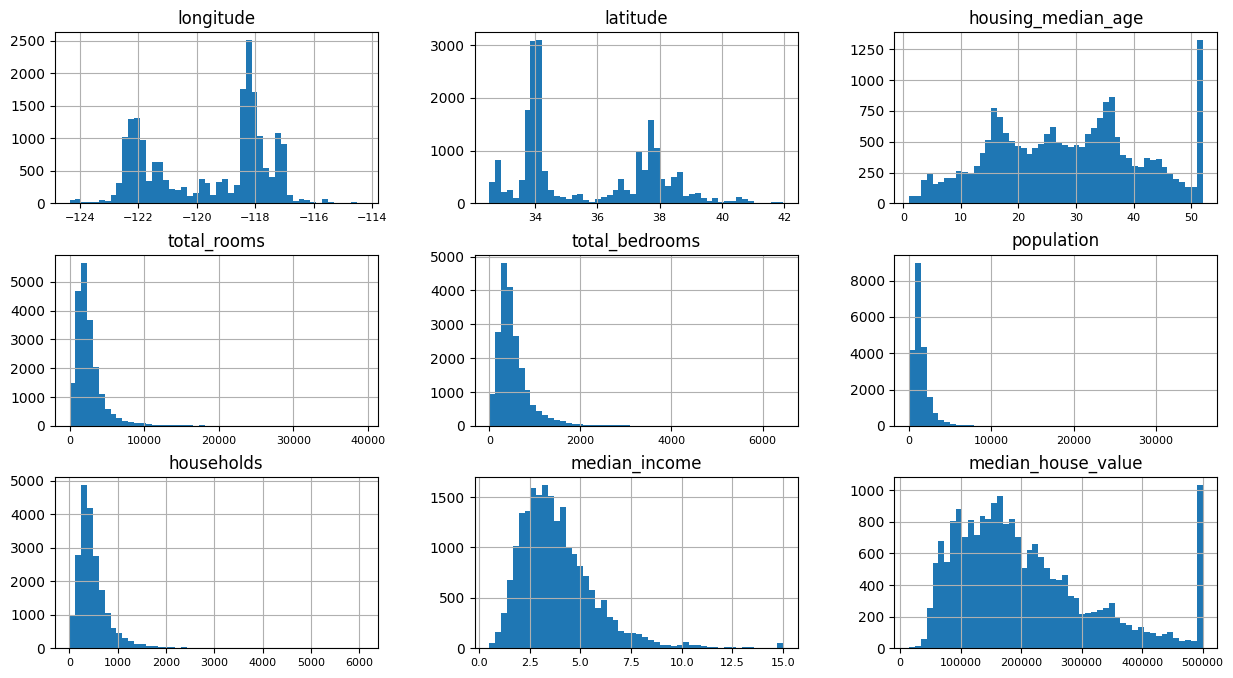

In [ ]:
housing.hist(bins=50, figsize=(15, 8),
                xlabelsize=8); # Reduce the size of x-axis labels so they don't overlap

The 'median_income' column may catch our attention, as it is not expressed in dollars. After consulting the [documentation](https://www.kaggle.com/datasets/camnugent/california-housing-prices), we see that the values in this column have been scaled and limited to a range of 0.5 to 15.0 (in fact, 15.0 is the maximum value it can take) and represent tens of thousands of dollars (for example, 3 actually means 30,000 USD).

Additionally, the 'housing_median_age' and 'median_house_value' columns have also been ***capped***. This can be deduced from the long column we see on the right of their histograms. Values above have been converted to that limit value. This process can sometimes be beneficial —for example, it reduces the impact of outliers on [scaling](e2e043_scaling.ipynb) and [imputation](e2e041_missing.ipynb) (see [Outliers and capped values](e2e020_eda.ipynb#Outliers-and-capped-values) for more details)— but it could also be a problem especially in "median_house_value", since it represents the output we want to predict. Our algorithms may erroneously learn that prices never exceed that limit. In these cases we should consult whether this can be a problem for the uses of our model. If we need accurate predictions even beyond 500,000 USD, then we would need to search for the real labels of districts with a 'median_house_value' of 500001. If we cannot obtain them, then we must remove those districts from the training and validation data (and also from the test data, since we don't want to evaluate our model with examples that will not be used in practice).

It is common to have to work with data that has been preprocessed, it is important to understand what criteria have been followed, and if possible, obtain the original data and preprocess it ourselves.

We can also see that several histograms have thicker tails to the right (see [Outliers and capped values](e2e020_eda.ipynb#Outliers-and-capped-values)). This can make it harder for some *Machine Learning* algorithms to detect patterns. We will try to transform these variables later so they have a more symmetric distribution (see [Heavy-tailed distributions](e2e043_scaling.ipynb#Heavy-tailed-distributions)).

This can also be observed in the relationship between the mean and median. For example, the mean in 'total_bedrooms' is 537.87, and the median is 435.00. This tells us that the distribution of values for this variable is skewed to the right, since the median is less than the mean. This is important to keep in mind, as it can affect how we handle missing values.

Another thing that may catch our attention is the 'ocean_proximity' column, which does not appear in the statistics summary. This is because it is a **categorical variable**, not numeric. It doesn't make sense to calculate statistics on it.

## Framing the problem

We therefore have the objective of training a *Machine Learning* model capable of predicting the median house price in any district of California. For this training we have a dataset with 20640 rows, each of which represents a district of California, and 10 columns with information about each district. One of the columns is the median house price in that district, which is what we want to predict; it is therefore the **target variable**. The other 9 columns are the **independent variables** or ***features***.

Having a continuous target variable (a **label** for each sample), we are facing a **supervised learning** problem. Additionally, since this variable is a continuous numerical value, we are facing a **regression** problem.

## Selection of performance measure

To evaluate the performance of our model, we will use the **Root Mean Squared Error (RMSE)**, a very common performance measure in regression problems.

### Performance metrics vs. loss functions

It's important to distinguish between related but different concepts:

- **Performance metrics** (or evaluation metrics): Functions used to **measure** how well a model performs. They are computed on predictions vs. actual values after training. Examples: RMSE, MAE, R², accuracy, F1-score.

- **Loss functions** (or cost functions): Functions that the learning algorithm tries to **minimize** during training. They guide the optimization process and must be differentiable for gradient-based methods. Examples: Mean Squared Error (MSE), Cross-Entropy.

**In regression**, the distinction is often blurred because the same function can serve both purposes. MSE is both a natural loss function (convex, differentiable, easy to optimize) and a meaningful metric. RMSE is simply $\sqrt{\text{MSE}}$, which has the advantage that its units match the target variable (dollars in our case), making it more interpretable.

**In classification**, the distinction is clearer. Cross-entropy is typically used as the loss function because it's smooth and differentiable, providing useful gradients for optimization. However, we often *evaluate* the model using metrics like accuracy, precision, recall, or F1-score—which are not differentiable (they involve counting discrete correct/incorrect predictions) and thus cannot be directly optimized.

### Why RMSE over MAE?

Both RMSE and MAE (Mean Absolute Error) are valid regression metrics, but they have different properties:

| Property | RMSE | MAE |
|----------|------|-----|
| Penalizes large errors | More heavily (squared) | Linearly |
| Sensitivity to outliers | Higher | Lower |
| Differentiability | Smooth everywhere | Not differentiable at 0 |
| Units | Same as target | Same as target |

RMSE is preferred when:
- Large errors are particularly undesirable (e.g., predicting a house at \$100k when it's worth \$500k is much worse than being off by \$50k twice)
- You want consistency with MSE-based optimization

MAE is preferred when:
- You want robustness to outliers
- All errors should be weighted equally regardless of magnitude

For housing prices, RMSE is a reasonable choice: significantly undervaluing or overvaluing a property has disproportionate consequences.

For a deeper understanding of regression metrics and their mathematical foundations, see the [Linear Regression notebook](../ia25/algorithms/linear_regression.ipynb).